# MLP with **PyTorch** — Binary Classification

In this notebook you'll train a small **Multi-Layer Perceptron (MLP)** using **PyTorch** on a simple 2-D synthetic dataset.

What you'll learn:
- Building a dataset (two Gaussian blobs) for binary classification  
- Defining an MLP with `torch.nn` modules  
- Compiling the training loop with an optimizer and loss function  
- Plotting **loss** and **accuracy** curves  
- Visualizing the **decision boundary**  


> **Note:** If `torch` isn't installed in your environment, please install it first.  
> In many environments: `pip install torch`  
> (Skip this if PyTorch is already available.)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility (best-effort)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cpu")  # Keep it simple and portable
device


device(type='cpu')

## 1) Create a Simple 2-D Dataset (Binary Classification)

Two clusters (class 0 and class 1). We'll split into train/test.


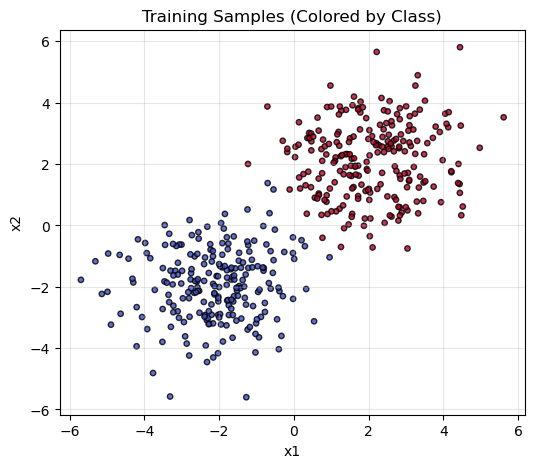

In [8]:
def make_blobs(n_per_class=200, spread=1.2):
    mean0 = np.array([-2.0, -2.0])
    mean1 = np.array([ 2.0,  2.0])
    cov = np.array([[spread, 0.0],[0.0, spread]])
    X0 = np.random.multivariate_normal(mean0, cov, n_per_class)
    X1 = np.random.multivariate_normal(mean1, cov, n_per_class)
    X = np.vstack([X0, X1]).astype("float32")
    y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)]).astype("float32")
    return X, y

X, y = make_blobs(n_per_class=300, spread=1.5)

# Train/test split
indices = np.arange(len(X))
np.random.shuffle(indices)
train_ratio = 0.75
split = int(train_ratio * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# Plot sample points with color based on class
plt.figure(figsize=(6, 5))
plt.scatter(
    X_train[:, 0], X_train[:, 1],
    c=y_train,           # color by class label (0 or 1)
    cmap='coolwarm',     # color map: blue–red
    s=15,                # point size
    alpha=0.8,           # transparency for better visibility
    edgecolors='k'       # black edge around points for clarity
)

plt.title("Training Samples (Colored by Class)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True, alpha=0.3)
plt.show()


# Build PyTorch datasets/loaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)


## 2) Define the MLP Model (`torch.nn`)

We'll use a small network:

- Linear(2→16) + ReLU → Linear(16→8) + ReLU → Linear(8→1)

We'll use **`BCEWithLogitsLoss`**, which expects raw scores (logits). We'll apply `sigmoid` only for metrics/visualization.


In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

## 3) Training Setup

- **Loss:** `BCEWithLogitsLoss`  
- **Optimizer:** `Adam` (learning rate 1e-2)  
- We'll track loss and accuracy per epoch.


In [4]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def accuracy_from_logits(logits, y_true):
    # logits: torch tensor (N,1), y_true: torch tensor (N,)
    probs = torch.sigmoid(logits).detach().cpu().numpy().squeeze()
    preds = (probs >= 0.5).astype(np.int32)
    return (preds == y_true.detach().cpu().numpy().astype(np.int32)).mean()


## 4) Train the Model


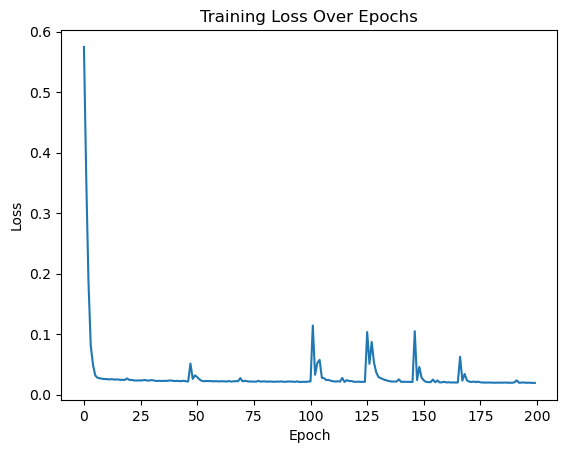

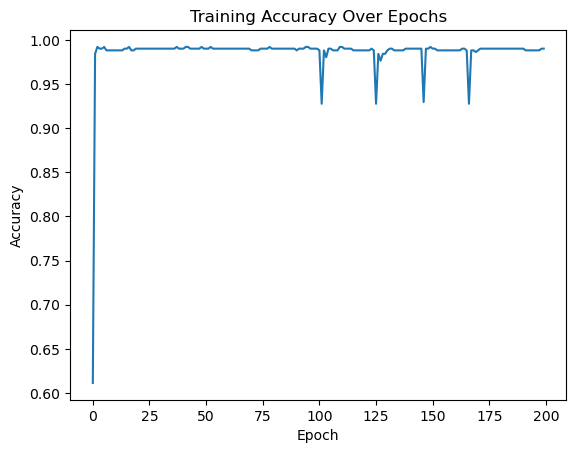

In [5]:
epochs = 200
train_loss_hist = []
train_acc_hist  = []

model.train()
for ep in range(1, epochs+1):
    epoch_losses = []
    epoch_accs   = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).view(-1, 1)  # shape (N,1)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy_from_logits(logits, yb.view(-1)))

    train_loss_hist.append(np.mean(epoch_losses))
    train_acc_hist.append(np.mean(epoch_accs))

# Plot loss
plt.figure()
plt.plot(train_loss_hist)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

# Plot accuracy
plt.figure()
plt.plot(train_acc_hist)
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.show()


## 5) Evaluate on the Test Set


In [6]:
model.eval()
test_losses = []
test_accs = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device).view(-1, 1)
        logits = model(xb)
        loss = criterion(logits, yb)
        test_losses.append(loss.item())
        test_accs.append(accuracy_from_logits(logits, yb.view(-1)))

print("Test loss:", round(float(np.mean(test_losses)), 4))
print("Test acc :", round(float(np.mean(test_accs)), 4))


Test loss: 0.0123
Test acc : 1.0


## 6) Visualize the Decision Boundary


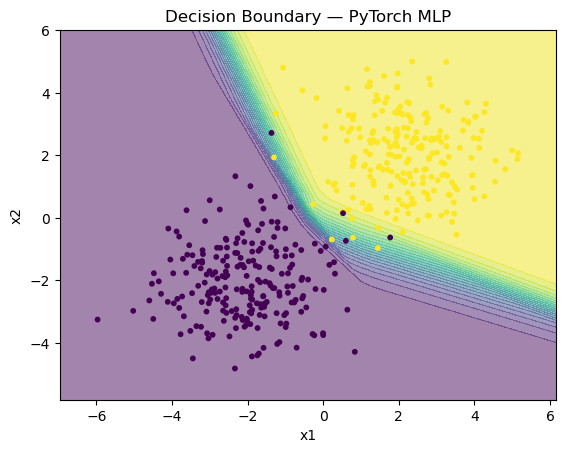

In [7]:
def plot_decision_boundary_torch(model, X, y, steps=200, padding=1.0):
    model.eval()
    x_min, x_max = X[:,0].min()-padding, X[:,0].max()+padding
    y_min, y_max = X[:,1].min()-padding, X[:,1].max()+padding
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, steps),
        np.linspace(y_min, y_max, steps)
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype("float32")
    with torch.no_grad():
        logits = model(torch.from_numpy(grid).to(device))
        probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, probs, levels=20, alpha=0.5)
    plt.scatter(X[:,0], X[:,1], c=y, s=10)
    plt.title("Decision Boundary — PyTorch MLP")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

plot_decision_boundary_torch(model, X_train, y_train)


## 7) Tips & Exercises

- Try different widths/depths: e.g., a single hidden layer vs. two.
- Tune learning rate: `1e-3` vs `1e-2` vs `5e-2`.
- Add regularization: `nn.Dropout(p=0.2)` or L2 via `weight_decay` in the optimizer.
- Replace ReLU with `nn.Tanh()` and compare learning curves.
- Increase blob overlap to make classification harder.
